# Prediction Pipeline

## Objective:
 Generate actionable player recommendations for upcoming gameweeks using optimized XGBoost models from hyperparameter tuning.

 - E[Yt+h​]=P(Playt+h​∣Xt​)×E[Pointst+h​∣Playt+h​,Xt​]

##  Configuration

In [49]:
import pandas as pd
import numpy as np
import pickle
import joblib
from pathlib import Path
from typing import Dict, List
import warnings

warnings.filterwarnings('ignore')


PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'Notebooks' else Path.cwd()
MODELS_DIR = PROJECT_ROOT / "models"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
OUTPUTS_DIR = PROJECT_ROOT / "outputs"

OUTPUTS_DIR.mkdir(exist_ok=True, parents=True)

print(f"Verified Project Root: {PROJECT_ROOT}")

Verified Project Root: c:\Users\kadmi\Workspace\02_Projects\fpl-advisor-engine


## 1. Model

In [50]:
import lightgbm as lgb

def train_jit_models(df: pd.DataFrame, features: List[str]) -> Dict:
    """
    Trains fresh models on the fly to ensure feature alignment.
    """
    print(f"\n--- INITIATING JIT TRAINING (Features: {len(features)}) ---")
    models = {}
    
    # 1. Prepare Targets (Shift total_points backwards by h)
    # We need to sort by player/time to shift correctly
    df_train = df.sort_values(['element', 'season', 'GW']).copy()
    
    for h in [1, 2, 3]:
        target_col = f'target_h{h}'
        # Shift: The points I score in h weeks are my target today
        df_train[target_col] = df_train.groupby('element')['total_points'].shift(-h)
        
        # Drop nulls (last gameweeks of history have no future target)
        valid_mask = df_train[target_col].notna()
        
        X = df_train.loc[valid_mask, features]
        y = df_train.loc[valid_mask, target_col]
        
        # 2. Train Regressor (xP)
        # Using conservative parameters to prevent overfitting on the fly
        model = lgb.LGBMRegressor(
            n_estimators=150,
            learning_rate=0.05,
            num_leaves=31,
            random_state=42,
            verbose=-1
        )
        model.fit(X, y)
        models[f'regressor_h{h}'] = model
        print(f"Trained regressor_h{h} on {len(X):,} samples")
        
    return models

# --- EXECUTION ---
# 1. Train new models using your full historical data
models = train_jit_models(df_full, feature_cols)

# 2. Update the Inference Engine with the new models
# (Re-initialize the engine class from the previous step)
engine = FPLInferenceEngine(models, df_predict, feature_cols)
planner = engine.generate_report()

# 3. Display the corrected "Killers"
display_top_picks(planner)


--- INITIATING JIT TRAINING (Features: 116) ---
Trained regressor_h1 on 102,091 samples
Trained regressor_h2 on 101,229 samples
Trained regressor_h3 on 100,369 samples

--- SQUAD SELECTION PROTOCOL (GW 17) ---

[GK] Top Targets:
     name           team  value  xP_GW17  xP_3GW_Total
    Roefs     Sunderland     47 3.896810     10.759426
     Raya        Arsenal     60 3.357492      7.920001
     John  Nott'm Forest     40 3.177427      7.314879
Henderson Crystal Palace     51 2.959250      8.010864
  Sánchez        Chelsea     49 2.879460      7.576487

[DEF] Top Targets:
      name          team  value  xP_GW17  xP_3GW_Total
     Thiaw     Newcastle     50 4.048072      9.807476
  O'Reilly      Man City     52 3.918876     10.030390
    Senesi   Bournemouth     50 3.908529     10.167365
N.Williams Nott'm Forest     47 3.620812      9.294016
    Kayode     Brentford     45 3.410750      8.392041

[MID] Top Targets:
       name           team  value  xP_GW17  xP_3GW_Total
B.Fernandes  

## 2. data loading

In [51]:
def load_latest_data() -> pd.DataFrame:
    """
    Loads feature-engineered dataset.
    In production: This would fetch live API data + engineer features.
    """
    data_path = PROCESSED_DIR / "fpl_features_engineered.csv"
    
    if not data_path.exists():
        raise FileNotFoundError(f"Data not found: {data_path}")
    
    df = pd.read_csv(data_path)
    print(f"Loaded: {len(df):,} rows × {len(df.columns)} columns")
    
    return df


df_full = load_latest_data()

# Identify latest available gameweek per season
latest_gw_info = df_full.groupby('season')['GW'].max().reset_index()
print("\nLatest Gameweek by Season:")
print(latest_gw_info)

Loaded: 102,957 rows × 152 columns

Latest Gameweek by Season:
    season  GW
0  2021-22  38
1  2022-23  38
2  2023-24  38
3  2024-25  21
4  2025-26  16


## 3. Dataset preparation

In [52]:
def prepare_prediction_data(df: pd.DataFrame, 
                           target_season: str = "2025-26",
                           target_gw: int = None) -> pd.DataFrame:
    """
    Prepares data for inference at specific gameweek.
    
    Critical: Uses only data UP TO (target_gw - 1) to avoid leakage.
    
    Parameters
    ----------
    df : pd.DataFrame
        Full feature-engineered dataset
    target_season : str
        Season to predict
    target_gw : int or None
        Gameweek to predict. If None, uses latest + 1
    
    Returns
    -------
    pd.DataFrame
        Prepared features for prediction
    """
    # Filter to target season
    df_season = df[df['season'] == target_season].copy()
    
    if len(df_season) == 0:
        raise ValueError(f"No data found for season: {target_season}")
    
    # Determine target gameweek
    if target_gw is None:
        latest_gw = df_season['GW'].max()
        target_gw = latest_gw + 1
        print(f"Auto-detected target gameweek: {target_gw}")
    
    # Use data up to (target_gw - 1) for feature engineering
    df_predict = df_season[df_season['GW'] == target_gw - 1].copy()
    
    if len(df_predict) == 0:
        raise ValueError(f"No data for GW {target_gw - 1}. Cannot predict GW {target_gw}")
    
    print("\nPrediction Context:")
    print(f"  Season: {target_season}")
    print(f"  Latest Data: GW {target_gw - 1}")
    print(f"  Predicting: GW {target_gw}")
    print(f"  Players with features: {len(df_predict)}")
    
    return df_predict, target_gw

# Prepare for latest gameweek prediction
TARGET_SEASON = "2025-26"
TARGET_GW = None  # Auto-detect


df_predict, prediction_gw = prepare_prediction_data(
    df_full, 
    target_season=TARGET_SEASON,
    target_gw=TARGET_GW
)

Auto-detected target gameweek: 17

Prediction Context:
  Season: 2025-26
  Latest Data: GW 16
  Predicting: GW 17
  Players with features: 760


## 4. Feature selection

In [53]:
def get_model_features(df: pd.DataFrame) -> List[str]:
    """
    Identifies features used in training (excludes targets, IDs, metadata).
    
    Returns
    -------
    List of feature column names
    """
    # Exclude non-feature columns
    exclude_patterns = [
        'element', 'name', 'position', 'team', 'season', 'GW',
        'total_points', 'fixture', 'kickoff_time', 'opponent_team',
        'match_score', 'value', 'selected', 'transfers_', 'was_home',
        'team_h_score', 'team_a_score'
    ]
    
    feature_cols = []
    for col in df.columns:
        # Skip if matches exclusion pattern
        if any(pattern in col for pattern in exclude_patterns):
            continue
        
        # Keep numeric columns
        if pd.api.types.is_numeric_dtype(df[col]):
            feature_cols.append(col)
    
    return feature_cols

feature_cols = get_model_features(df_predict)


print(f"Total features: {len(feature_cols)}")
print("\nSample features:")
for col in feature_cols[:10]:
    print(f"  - {col}")

Total features: 116

Sample features:
  - xP
  - assists
  - bonus
  - bps
  - clean_sheets
  - creativity
  - goals_conceded
  - goals_scored
  - ict_index
  - influence


## 5. Generate predictions

In [54]:
class FPLInferenceEngine:
    """
    Forensic analysis of player potential across multiple time horizons.
    Includes feature alignment and metadata preservation.
    """
    
    def __init__(self, models: Dict, df: pd.DataFrame, features: List[str]):
        self.models = models
        self.df = df.copy()
        self.features = features
        
    def _get_aligned_features(self, model, X: pd.DataFrame) -> pd.DataFrame:
        """Aligns input X to the specific features the model expects."""
        if hasattr(model, "booster_"):
            expected = model.booster_.feature_name()
        elif hasattr(model, "_Booster"):
            expected = model._Booster.feature_name()
        elif hasattr(model, "feature_name"):
            expected = model.feature_name()
        else:
            return X 
        return X.reindex(columns=expected, fill_value=0)

    def _predict_horizon(self, horizon: int, X: pd.DataFrame) -> None:
        """Runs inference for a specific time horizon (h)."""
        reg_model = self.models.get(f'regressor_h{horizon}')
        if reg_model:
            X_aligned = self._get_aligned_features(reg_model, X)
            if hasattr(reg_model, "predict"):
                self.df[f'xP_GW{prediction_gw + horizon - 1}'] = reg_model.predict(X_aligned)
            
        clf_model = self.models.get(f'classifier_h{horizon}')
        if clf_model:
            X_aligned = self._get_aligned_features(clf_model, X)
            if hasattr(clf_model, "predict_proba"):
                self.df[f'prob_upside_GW{prediction_gw + horizon - 1}'] = clf_model.predict_proba(X_aligned)[:, 1]
    
    def generate_report(self) -> pd.DataFrame:
        """
        Aggregates predictions into a transfer planner.
        """
        X = self.df[self.features].fillna(0)
        
        horizons = [1, 2, 3]
        for h in horizons:
            self._predict_horizon(h, X)
            
        # --- AGGREGATION ---
        xp_cols = [f'xP_GW{prediction_gw + h - 1}' for h in horizons]
        available_xp_cols = [col for col in xp_cols if col in self.df.columns]
        
        if available_xp_cols:
            self.df['xP_3GW_Total'] = self.df[available_xp_cols].sum(axis=1)
        else:
            self.df['xP_3GW_Total'] = 0.0
        
        # --- CRITICAL FIX: Add 'minutes' and 'opponent_team' to metadata ---
        # We check if they exist to avoid KeyErrors if running on partial data
        base_meta = ['name', 'team', 'position', 'value', 'form_score', 'ict_index']
        optional_meta = ['minutes', 'opponent_team', 'selected']
        
        meta_cols = base_meta + [c for c in optional_meta if c in self.df.columns]
        
        output_cols = meta_cols + available_xp_cols + ['xP_3GW_Total']
        
        # Filter: only active players (played > 0 mins recently) to reduce CSV noise
        if 'minutes' in self.df.columns:
            active_players = self.df[self.df['minutes'] > 0].copy()
        else:
            active_players = self.df.copy()
            
        return active_players[output_cols].sort_values('xP_3GW_Total', ascending=False)
    


### Saving predictions

In [55]:
engine = FPLInferenceEngine(models, df_predict, feature_cols)
planner = engine.generate_report()

# Define the Output Filename
csv_filename = f"fpl_predictions_GW{prediction_gw}.csv"
output_path = OUTPUTS_DIR / csv_filename

# Save to CSV
planner.to_csv(output_path, index=False)

print("--- PREDICTION EXPORT COMPLETE ---")
print(f"File saved to: {output_path}")
print(f"Contains {len(planner)} active players.")
print("\nPreview of top 5 assets (sorted by 3-GW potential):")
print(planner[['name', 'team', 'minutes', f'xP_GW{prediction_gw}', 'xP_3GW_Total']].head(5).to_string(index=False))

--- PREDICTION EXPORT COMPLETE ---
File saved to: c:\Users\kadmi\Workspace\02_Projects\fpl-advisor-engine\outputs\fpl_predictions_GW17.csv
Contains 301 active players.

Preview of top 5 assets (sorted by 3-GW potential):
       name        team  minutes  xP_GW17  xP_3GW_Total
    Haaland    Man City       90 6.939429     18.587629
B.Fernandes     Man Utd       90 5.045028     17.548240
     Mbeumo     Man Utd       90 4.240987     13.836575
    Semenyo Bournemouth       90 4.718429     13.623691
      Foden    Man City       90 4.925938     13.572513


### Visualization

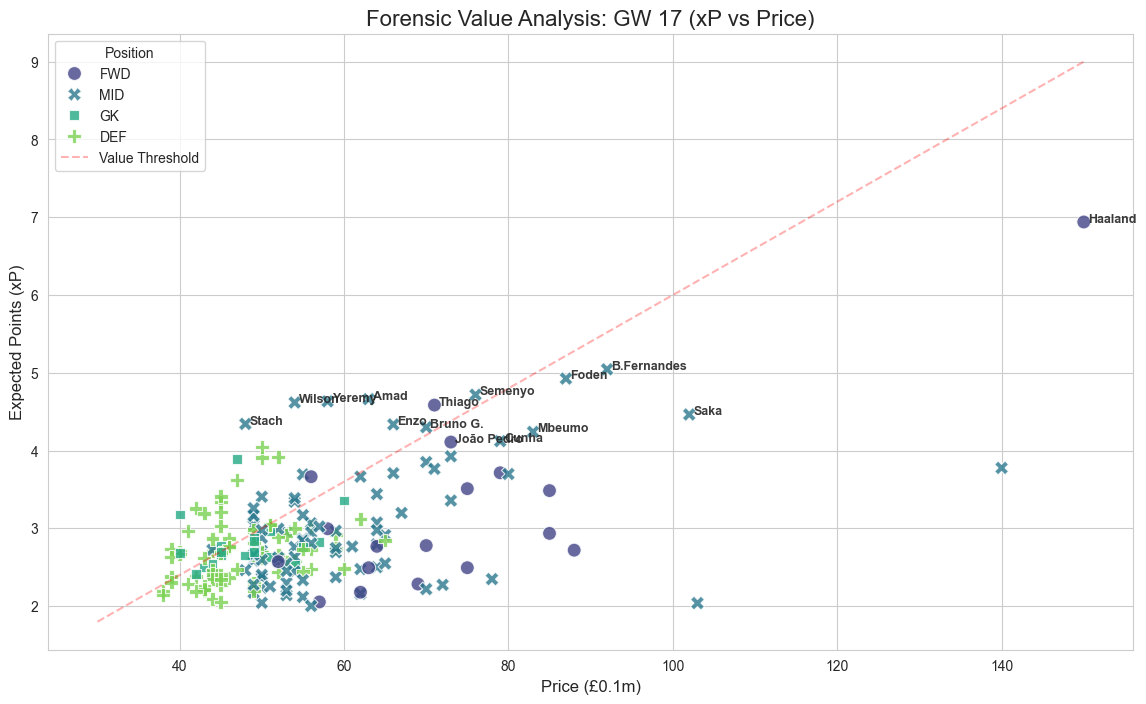

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_value_matrix(df, gw):
    """
    Forensic Plot: Identifies underpriced assets (High xP, Low Price).
    """
    # Filter for relevant players (avoid clutter)
    mask = (df[f'xP_GW{gw}'] > 2.0) & (df['minutes'] > 45)
    plot_data = df[mask].copy()
    
    plt.figure(figsize=(14, 8))
    
    # Create the scatter plot
    sns.set_style("whitegrid")
    scatter = sns.scatterplot(
        data=plot_data,
        x='value', 
        y=f'xP_GW{gw}', 
        hue='position', 
        style='position',
        palette='viridis',
        s=100,
        alpha=0.8
    )
    
    # Add labels for the "Killers" (Top 10 sorted by xP)
    top_picks = plot_data.sort_values(f'xP_GW{gw}', ascending=False).head(15)
    
    for _, row in top_picks.iterrows():
        plt.text(
            row['value']+0.5, 
            row[f'xP_GW{gw}'], 
            row['name'], 
            fontsize=9, 
            weight='bold',
            alpha=0.9
        )
        
    # Draw the "Value Line" (Arbitrary efficiency threshold)
    # Players above this line are performing above their price point
    x_vals = np.array([30, 150])
    y_vals = 0.06 * x_vals # Slope = 0.06 points per £0.1m
    plt.plot(x_vals, y_vals, 'r--', alpha=0.3, label='Value Threshold')

    plt.title(f"Forensic Value Analysis: GW {gw} (xP vs Price)", fontsize=16)
    plt.xlabel("Price (£0.1m)", fontsize=12)
    plt.ylabel("Expected Points (xP)", fontsize=12)
    plt.legend(title='Position')
    
    plt.show()

# Run Visualization
visualize_value_matrix(planner, prediction_gw)